In [1]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import string
import numpy as np

In [2]:
ROOT_PATH = Path().absolute().parent

In [3]:
data_path = ROOT_PATH.joinpath('data')

In [4]:
save_path = ROOT_PATH.joinpath('notebooks', 'visuals')

In [23]:
# flickr8k
#f8_path = data_path.joinpath('interim', 'flickr8k', 'flickr8k_train.csv')
#flick30k
#f30_path = data_path.joinpath('interim', 'karpathy_split', 'flickr30k_train.csv')
#MSCOCO
coco_path = data_path.joinpath('interim', 'karpathy_split', 'coco_train.csv')

In [24]:
#f8_df = pd.read_csv(f8_path)
#f30_df = pd.read_csv(f30_path)
coco_df = pd.read_csv(coco_path)

In [22]:
f8_df

,Unnamed: 0,Unnamed: 0.1,image_id,caption_id,caption
0,0,0,1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg#0,A child in a pink dress is climbing up a set o...
1,1,1,1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg#1,A girl going into a wooden building .
2,2,2,1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg#2,A little girl climbing into a wooden playhouse .
3,3,3,1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg#3,A little girl climbing the stairs to her playh...
4,4,4,1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg#4,A little girl in a pink dress going into a woo...
...,...,...,...,...,...
29995,40450,40450,997338199_7343367d7f.jpg,997338199_7343367d7f.jpg#0,A person stands near golden walls .
29996,40451,40451,997338199_7343367d7f.jpg,997338199_7343367d7f.jpg#1,a woman behind a scrolled wall is writing
29997,40452,40452,997338199_7343367d7f.jpg,997338199_7343367d7f.jpg#2,A woman standing near a decorated wall writes .
29998,40453,40453,997338199_7343367d7f.jpg,997338199_7343367d7f.jpg#3,The walls are covered in gold and patterns .


In [21]:
f8_captions = f8_df.loc[:, ['image_id', 'caption']]


In [5]:
stop_words = set(['a', 'the'])
k = 15

In [6]:
def words_total(df):
    # returns total number of words in corpus
    count = 0
    for c in df.loc[:, 'caption']:
        c = [w.strip() for w in c.split()]
        c = [w.lower() for w in c]
        c = [w.translate(table) for w in c]
        c = [w for w in c if len(w) > 1 or w == 'a']
        c = [w for w in c if w.isalpha()]
        count += len(c)
    return count
    

In [7]:
table = str.maketrans('', '', string.punctuation)

In [8]:
def word_frequency_dict(df):
    d = {}
    for c in df.loc[:, 'caption']:
        c = [w.strip() for w in c.split()]
        c = [w.lower() for w in c]
        c = [w.translate(table) for w in c]
        c = [w for w in c if len(w) > 1 or w == 'a']
        c = [w for w in c if w.isalpha()]

        for w in c:
            if w not in stop_words:
                if w not in d.keys():
                    d[w] = 1
                else:
                    d[w] += 1
    return d
    

In [9]:
def find_k_most_frequent(wf_d, k=25):
    ws = []
    fs = []
    least_frequent_w = ''
    lf_f = 1000000
    for word, f in wf_d.items():
        if len(ws) < k:
            ws.append(word)
            fs.append(f)
            if f < lf_f:
                least_frequent_w = word
                lf_f = f
        else:
            # must replace the k most frequent word
            if f > lf_f:
                # is top k
                ws.remove(least_frequent_w)
                fs.remove(lf_f)
                ws.append(word)
                fs.append(f)
                lf_f = min(fs)
                for w_ in ws:
                    if wf_d[w_] == lf_f:
                        least_frequent_w = w_
                        break
    wf_d_out = {w: f for w, f in wf_d.items() if w in set(ws)}
    return wf_d_out

In [10]:
def caption_stats(df):
    lengths = []
    max_len_cap = 'UNK'
    min_len_cap = 'UNK'
    max_len = -1
    min_len = float('inf')
    max_im = 'UNK.jpg'
    min_im = 'UNK.jpg'
    for i in range(len(df)):
        # do basic preprocessing
        c = df.loc[i, 'caption']
        c = [w.strip() for w in c.split()]
        c = [w.lower() for w in c]
        c = [w.translate(table) for w in c]
        c = [w for w in c if len(w) > 1 or w == 'a']
        c = [w for w in c if w.isalpha()]
        # add to lengths
        lengths.append(len(c))
        if len(c) < min_len:
            # find out if this caption c is the shortest at this point
            min_len = len(c)
            min_len_cap = ' '.join(c)
            min_im = df.loc[i, 'image_id']
        if len(c) > max_len:
            # find out if this caption is the longest encountered at this point
            max_len = len(c)
            max_len_cap = ' '.join(c)
            max_im = df.loc[i, 'image_id']
    print('min:', min_len_cap, 'image:',  min_im)
    print('max:', max_len_cap, 'image:', max_im)
    lengths = np.array(lengths)
    return [np.max(lengths), np.min(lengths), np.mean(lengths), np.median(lengths), np.std(lengths)]

In [30]:
# wordfrequency in f8 overall
wf8_d = word_frequency_dict(f8_captions)
wf8_25f = find_k_most_frequent(wf8_d, k)
print(wf8_25f)

{'in': 14085, 'is': 6907, 'of': 4967, 'girl': 2414, 'black': 2854, 'dog': 6159, 'and': 6672, 'are': 2619, 'with': 5763, 'on': 8006, 'white': 2921, 'two': 4246, 'man': 5374, 'boy': 2634, 'woman': 2543}


In [31]:
f8_word_count = words_total(f8_captions)
f8_labels = [key for key in wf8_25f.keys()]
f8_values = [wf8_25f[key]/f8_word_count for key in wf8_25f.keys()]

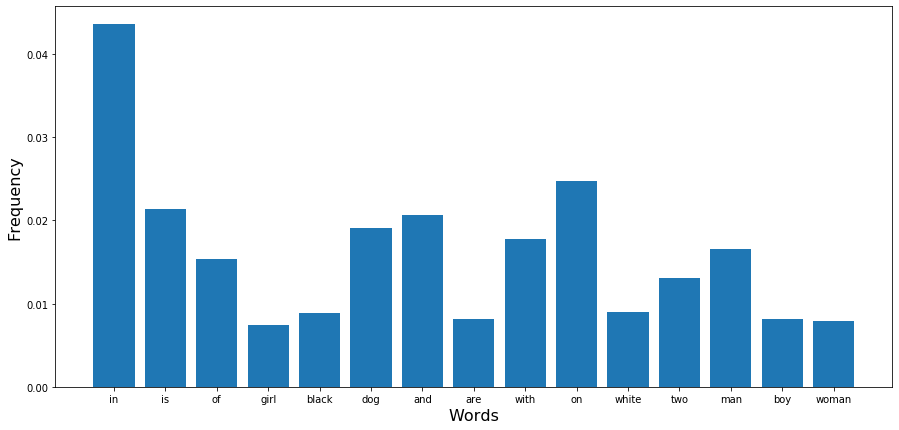

In [32]:
plt.figure(figsize=(15,7))
plt.bar(f8_labels, f8_values)
#plt.title("25 most frequent words in captions in the Flickr8k training set")
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Words', fontsize=16)
plt.savefig(save_path.joinpath('freq_15words_flickr8k.pdf'))
plt.show()

In [33]:
# wordfrequency in f30 overall
wf30_d = word_frequency_dict(f30_df)
wf30_25f = find_k_most_frequent(wf30_d, k)
print(wf30_25f)

{'two': 19599, 'with': 33168, 'at': 14888, 'in': 76202, 'are': 18439, 'man': 38831, 'on': 41580, 'of': 35571, 'wearing': 14319, 'is': 37659, 'an': 14591, 'to': 16126, 'and': 40420, 'people': 15888, 'woman': 20145}


In [34]:
f30_word_count = words_total(f30_df)
f30_labels = [key for key in wf30_25f.keys()]
f30_values = [wf30_25f[key]/f30_word_count for key in wf30_25f.keys()]

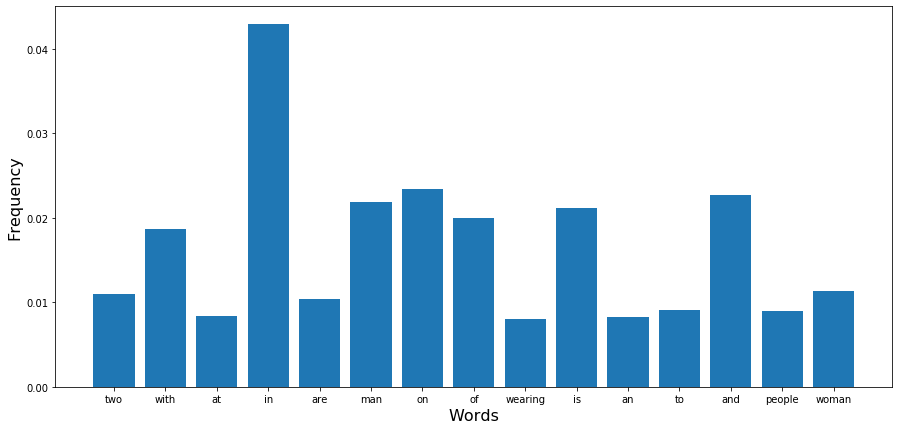

In [35]:
plt.figure(figsize=(15,7))
plt.bar(f30_labels, f30_values)
#plt.title("25 most frequent words in captions in the Flickr30k training set")
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Words', fontsize=16)
plt.savefig(save_path.joinpath('freq15_words_flickr30k.pdf'))
plt.show()

In [26]:
# wordfrequency in coco overall
wfcoco_d = word_frequency_dict(coco_df)
wfcoco_25f = find_k_most_frequent(wfcoco_d, k)
print(wfcoco_25f)

{'on': 206496, 'is': 94141, 'with': 148027, 'of': 195190, 'standing': 40771, 'in': 176167, 'and': 134750, 'at': 40917, 'to': 65327, 'people': 40327, 'sitting': 50570, 'man': 70052, 'two': 46483, 'are': 39375, 'an': 47672}


In [27]:
coco_word_count = words_total(coco_df)
print(coco_word_count)
coco_labels = [key for key in wfcoco_25f.keys()]
coco_values = [wfcoco_25f[key]/coco_word_count for key in wfcoco_25f.keys()]

5922264


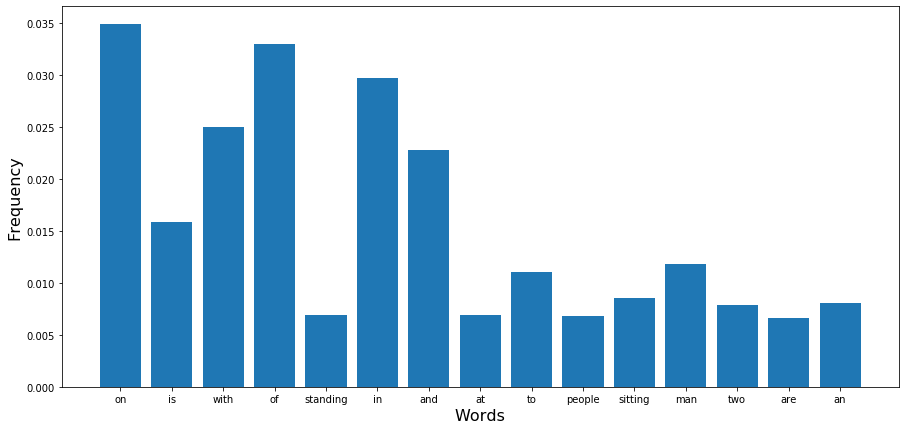

In [28]:
plt.figure(figsize=(15,7))
plt.bar(coco_labels, coco_values)
#plt.title("25 most frequent words in captions in the MS COCO training set")
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Words', fontsize=16)
plt.savefig(save_path.joinpath('freq15_words_MSCOCO.pdf'))
plt.show()

In [29]:
# get stats
#f8_stats = caption_stats(f8_captions)
#f30_stats = caption_stats(f30_df)
coco_stats = caption_stats(coco_df)

min: mmm image: 107506
max: a large square concrete wall which shows people over the rim has inside of it a pinkish cloud of dust and a fallen bull as well as two horses the closest of which is trotting forward with a man in western gear who is looking back at the bull image: 25075


In [30]:
#print('f8\nmax:', f8_stats[0], '\nmin:', f8_stats[1], '\nmean:', f8_stats[2], '\nmedian:', f8_stats[3], '\nstd:', f8_stats[4])
#print('f30\nmax:', f30_stats[0], '\nmin:', f30_stats[1], '\nmean:', f30_stats[2], '\nmedian:', f30_stats[3], '\nstd:', f30_stats[4])
print('coco\nmax:', coco_stats[0], '\nmin:', coco_stats[1], '\nmean:', coco_stats[2], '\nmedian:', coco_stats[3], '\nstd:', coco_stats[4])

coco
max: 49 
min: 1 
mean: 10.449572737041397 
median: 10.0 
std: 2.392557470977707


In [43]:
coco_df.loc[coco_df.loc[:, 'image_id'] == 'COCO_train2014_000000281091.jpg', ['image_id', 'caption_id', 'caption']]

,image_id,caption_id,caption
335167,COCO_train2014_000000281091.jpg,COCO_train2014_000000281091.jpg#COCO_train2014...,m m m m m m m m mmm m m m m
335168,COCO_train2014_000000281091.jpg,COCO_train2014_000000281091.jpg#COCO_train2014...,Man in a grassy meadow with a bunch of cows.
335169,COCO_train2014_000000281091.jpg,COCO_train2014_000000281091.jpg#COCO_train2014...,a man in a black shirt grass and some brown an...
335170,COCO_train2014_000000281091.jpg,COCO_train2014_000000281091.jpg#COCO_train2014...,a couple of cows are standing in a green field
335171,COCO_train2014_000000281091.jpg,COCO_train2014_000000281091.jpg#COCO_train2014...,A man tending to some of his cattle in a field


In [11]:
def caps_with_len(df, l):
    caps = []
    for i in range(len(df)):
        c = df.loc[i, 'caption']
        c = [w.strip() for w in c.split()]
        c = [w.lower() for w in c]
        c = [w.translate(table) for w in c]
        c = [w for w in c if len(w) > 1 or w == 'a']
        c = [w for w in c if w.isalpha()]
        if len(c) == l:
            caps.append(' '.join(c))
    return caps
    

In [45]:
caps_with_len(coco_df,5)

['mm mmm mm mm mmm', 'person snowboarding down a hill', 'corner of ave and st']

In [46]:
clean_coco_path = data_path.joinpath('interim', 'karpathy_split', 'coco_train_clean.csv')

In [47]:
clean_coco_df = pd.read_csv(clean_coco_path)

In [48]:
caps_with_len(clean_coco_df,5)

['person snowboarding down a hill', 'corner of ave and st']

In [49]:
clean_coco_df.loc[clean_coco_df.loc[:, 'image_id'] == 'COCO_train2014_000000281091.jpg', ['image_id', 'caption_id', 'caption', 'clean_caption']]

,image_id,caption_id,caption,clean_caption
335162,COCO_train2014_000000281091.jpg,COCO_train2014_000000281091#627298,Man in a grassy meadow with a bunch of cows.,startseq man in a grassy meadow with a bunch o...
335163,COCO_train2014_000000281091.jpg,COCO_train2014_000000281091#628777,a man in a black shirt grass and some brown an...,startseq a man in a black shirt grass and some...
335164,COCO_train2014_000000281091.jpg,COCO_train2014_000000281091#629962,a couple of cows are standing in a green field,startseq a couple of cows are standing in a gr...
335165,COCO_train2014_000000281091.jpg,COCO_train2014_000000281091#631009,A man tending to some of his cattle in a field,startseq a man tending to some of his cattle i...


## Paraphrases

In [12]:
para_path = data_path.joinpath('external', 'p5.csv')

In [13]:
para_df = pd.read_csv(para_path)

In [14]:
para_stats = caption_stats(para_df)

min: org image: 57335
max: bottom view of the head neck and legs with a white dog with black spots looking at the camera with the tabs on the window sill of an open window with a left pane closed and open shutter on the right a white brick building with rusty gutter at the top with blue sky image: 66609


In [15]:
print('coco\nmax:', para_stats[0], '\nmin:', para_stats[1], '\nmean:', para_stats[2], '\nmedian:', para_stats[3], '\nstd:', para_stats[4])

coco
max: 54 
min: 1 
mean: 9.984159919475175 
median: 10.0 
std: 2.539128585770941


In [17]:
# wordfrequency in coco overall
wfpara_d = word_frequency_dict(para_df)
wfpara_25f = find_k_most_frequent(wfpara_d, k)
print(wfpara_25f)

{'with': 150399, 'of': 183971, 'is': 61002, 'white': 34338, 'on': 210908, 'and': 134430, 'standing': 40385, 'in': 187783, 'people': 39310, 'sitting': 49246, 'to': 70573, 'man': 70262, 'two': 49679, 'next': 34875, 'an': 43222}


In [20]:
para_word_count = words_total(para_df)
print(para_word_count)
para_labels = [key for key in wfpara_25f.keys()]
para_values = [wfpara_25f[key]/para_word_count for key in wfpara_25f.keys()]

5653880


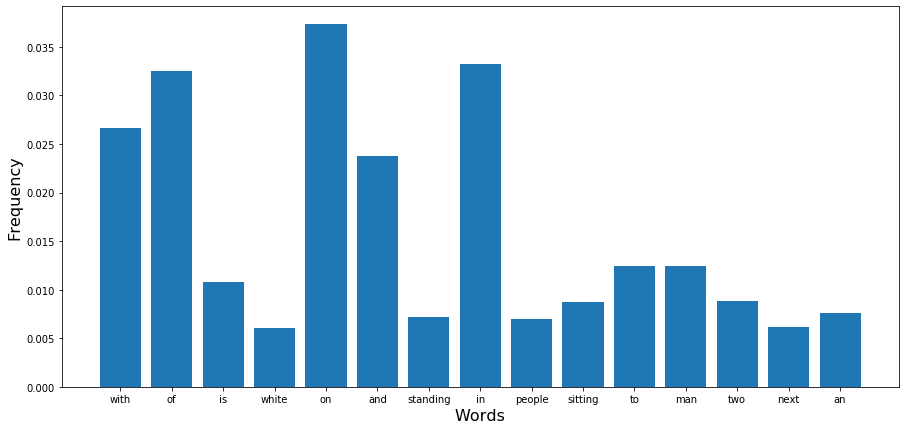

In [19]:
plt.figure(figsize=(15,7))
plt.bar(para_labels, para_values)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Words', fontsize=16)
plt.savefig(save_path.joinpath('freq15_words_paraphrases.pdf'))
plt.show()

In [31]:
caps_with_len(para_df,1)

['org']

In [35]:
for i in range(len(para_df)):
    caption = para_df.loc[i, 'caption']
    if caption=='org':
        print(para_df.loc[i, ['image_name', 'caption_id', 'caption']])

# Caption length visualization

In [3]:
cl_coco_path = ROOT_PATH.joinpath('data','interim','karpathy_split','coco_train_clean.csv')
coco_df = pd.read_csv(cl_coco_path)

In [6]:
caps = [c for c in coco_df.loc[:, 'caption']]
cap_lens = []
for c in caps:
    c = [w.strip() for w in c.split()]
    c = [w.lower() for w in c]
    c = [w.translate(table) for w in c]
    c = [w for w in c if len(w) > 1 or w == 'a']
    c = [w for w in c if w.isalpha()]
    cap_lens.append(len(c))

cap_labels = list(set(cap_lens))
print(max(cap_labels))
cap_values = {key: 0 for key in cap_labels}
for num in cap_lens:
    cap_values[num] += 1
cap_labels = [key for key in cap_values.keys()]
cap_values = [cap_values[key] for key in cap_values.keys()]

49


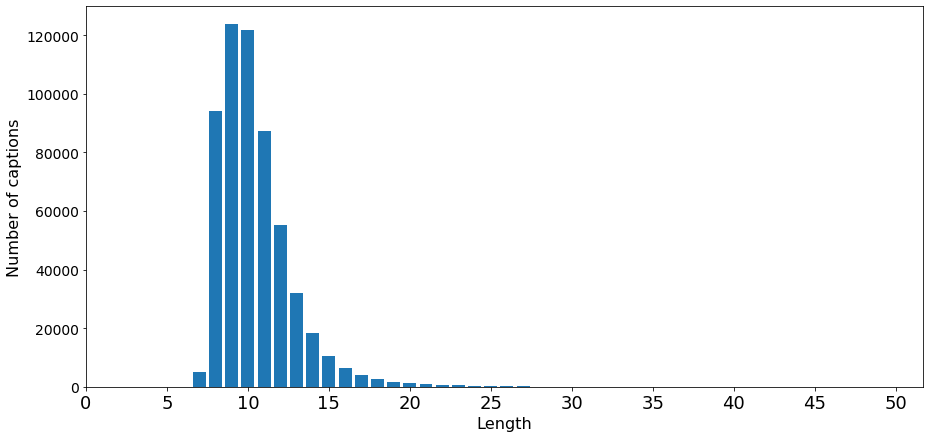

In [17]:
plt.figure(figsize=(15,7))
x_ticks = np.arange(0, 51, 5)
plt.bar(cap_labels, cap_values)
plt.ylabel('Number of captions', fontsize=16)
plt.xlabel('Length', fontsize=16)
plt.xticks(x_ticks, fontsize=18)
plt.yticks(fontsize=14)
plt.savefig(save_path.joinpath('coco_cap_lens.pdf'))
plt.show()

In [10]:
total_caps = len(cap_lens)
under_17 = len([l for l in cap_lens if l < 17])
print(under_17/total_caps)

0.9775284665891442
